In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

import dgl
from dgl import DGLGraph
import networkx as nx
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.manifold import TSNE

Using backend: pytorch


In [2]:
from dgl.data import citation_graph as citegrh

# load dataset, can specify 'cora','citeseer','pubmed'
dataset = 'cora'
if dataset == 'cora':
    data = citegrh.load_cora()
if dataset == 'citeseer':
    data = citegrh.load_citeseer()
if dataset == 'pubmed':
    data = citegrh.load_pubmed()
    
features = torch.FloatTensor(data.features)
labels = torch.LongTensor(data.labels)
if hasattr(torch, 'BoolTensor'):
    train_mask = torch.BoolTensor(data.train_mask)
    val_mask = torch.BoolTensor(data.val_mask)
    test_mask = torch.BoolTensor(data.test_mask)
else:
    train_mask = torch.ByteTensor(data.train_mask)
    val_mask = torch.ByteTensor(data.val_mask)
    test_mask = torch.ByteTensor(data.test_mask)
in_feats = features.shape[1]
n_classes = data.num_labels
n_edges = data.graph.number_of_edges()

# graph preprocess
g = data.graph
# add self loop
self_loop = True
if self_loop:
    g.remove_edges_from(nx.selfloop_edges(g))
    g.add_edges_from(zip(g.nodes(),g.nodes()))
g = DGLGraph(g)
n_edges = g.number_of_edges()

Visualize sample citation network (CORA)

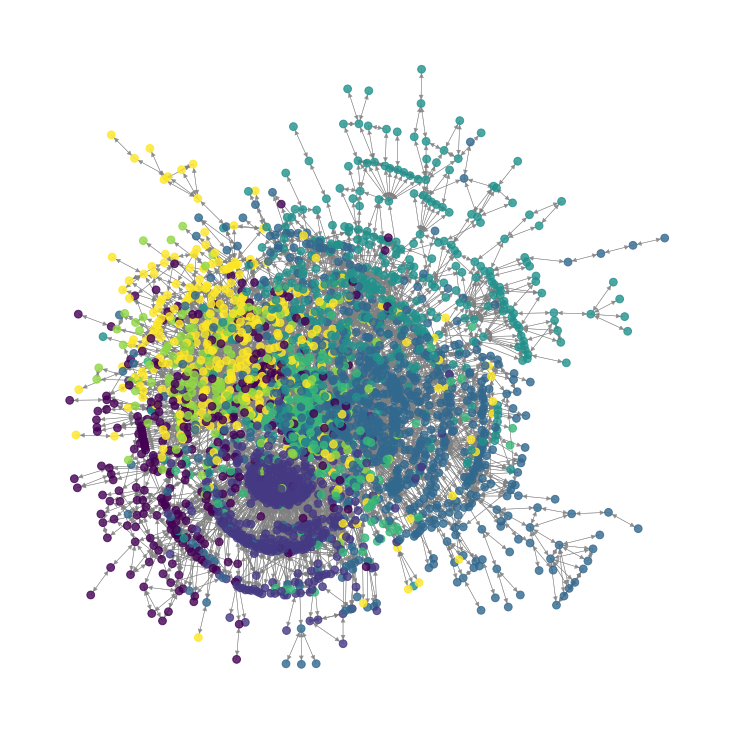

In [3]:
nx_g = data.graph
fig = plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, node_size=60, node_color=labels, width=.5, edge_color='grey',alpha=.8)

Visualize t-SNE of citation network features

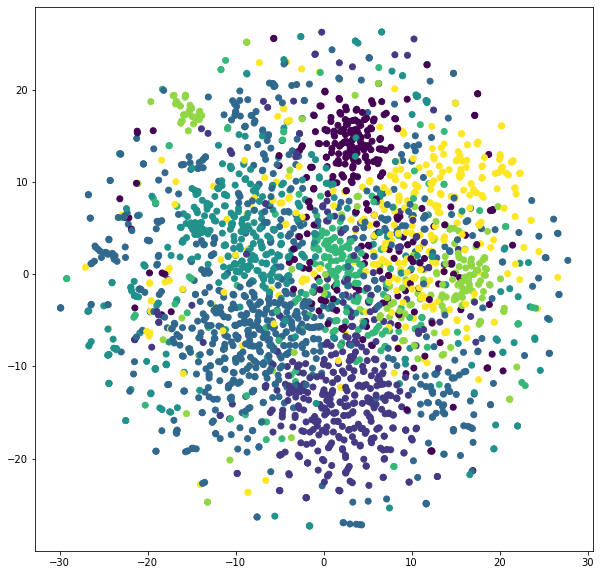

In [4]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(features)
x = tsne_results[:,0]
y = tsne_results[:,1]
fig = plt.figure(figsize=(10,10))
plt.scatter(x,y,c=labels,alpha=1)

Model demos

In [5]:
from utils import process_models as process
from unsupervised_models.gae import GAE
from unsupervised_models.vgae import VGAE
from unsupervised_models.dgi import DGI

Graph Autoencoder

/home/geoff/.virtualenvs/dgl/lib/python3.8/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


Model: Graph Autoencoder
Epoch 00399 | Time(s) 0.0525 | Loss 0.8209 | Last epoch! 


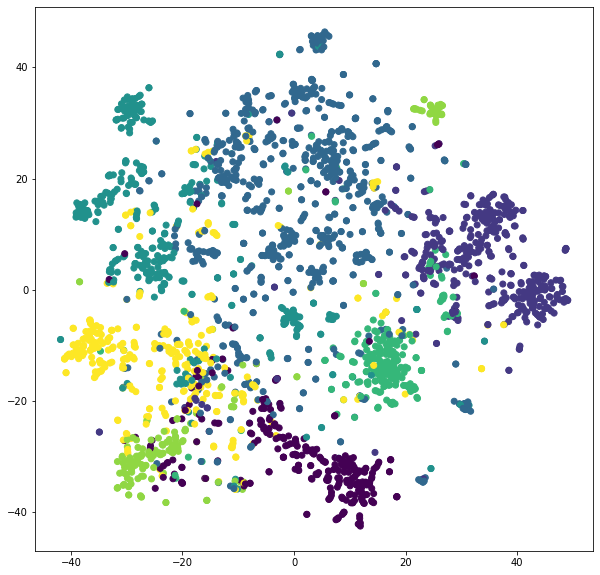

In [6]:
dropout = .4
hidden_dims = [256,256]
activation = nn.PReLU(hidden_dims[-1])
n_epochs=400
patience=40

hyperparameters = {}
hyperparameters['lr'] = .01
hyperparameters['weight_decay'] = 0.
hyperparameters['neg_sample_size'] = 1

# Train model
gae = GAE(g,in_feats,hidden_dims,activation=activation,dropout=dropout)
process.train_model(gae,features,hyperparameters,'cora_gae', \
                    n_epochs=n_epochs,patience=patience, \
                    saved_dir='saved_models',verbose=False)

# Load model
gae.load_state_dict(torch.load(os.path.join('saved_models', \
                                            'cora_gae.pkl')))

# Embed nodes with model
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
embeds = gae.encoder(features)
embeds = embeds.detach()

# Visualize
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(embeds)
x = tsne_results[:,0]
y = tsne_results[:,1]
fig = plt.figure(figsize=(10,10))
plt.scatter(x,y,c=labels,alpha=1.)

Normal Variational Graph Autoencoder

/home/geoff/.virtualenvs/dgl/lib/python3.8/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


Model: Normal Variational Graph Autoencoder
Epoch 00179 | Time(s) 0.0745 | Loss 0.9690 | Early stopping! 


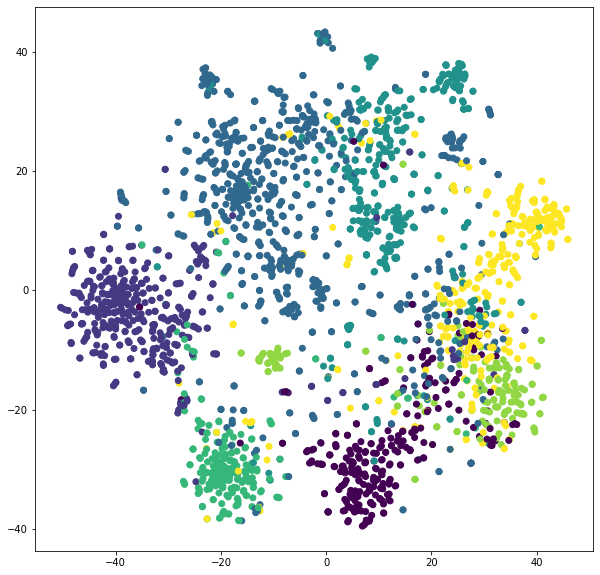

In [7]:
dropout = .4
hidden_dims = [256,256]
activation = nn.PReLU(hidden_dims[-1])
n_epochs=400
patience=40

hyperparameters = {}
hyperparameters['lr'] = .01
hyperparameters['weight_decay'] = 0.
hyperparameters['neg_sample_size'] = 1
hyperparameters['KL_weight'] = 1.

# Train model
nvgae = VGAE(g,in_feats,hidden_dims,activation=activation,dropout=dropout,distribution='normal')
process.train_model(nvgae,features,hyperparameters,'cora_nvgae', \
                    n_epochs=n_epochs,patience=patience, \
                    saved_dir='saved_models',verbose=False)

# Load model
nvgae.load_state_dict(torch.load(os.path.join('saved_models', \
                                            'cora_nvgae.pkl')))

# Embed nodes with model
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
embeds = nvgae.encoder(features)
(embeds, embeds_var) = nvgae.encoder(features)
embeds = embeds.detach()

# Visualize
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(embeds)
x = tsne_results[:,0]
y = tsne_results[:,1]
fig = plt.figure(figsize=(10,10))
plt.scatter(x,y,c=labels,alpha=1.)

Spherical Variational Graph Autoencoder

/home/geoff/.virtualenvs/dgl/lib/python3.8/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


Model: Spherical Variational Graph Autoencoder
Epoch 00399 | Time(s) 0.0546 | Loss 1.1800 | Last epoch! 


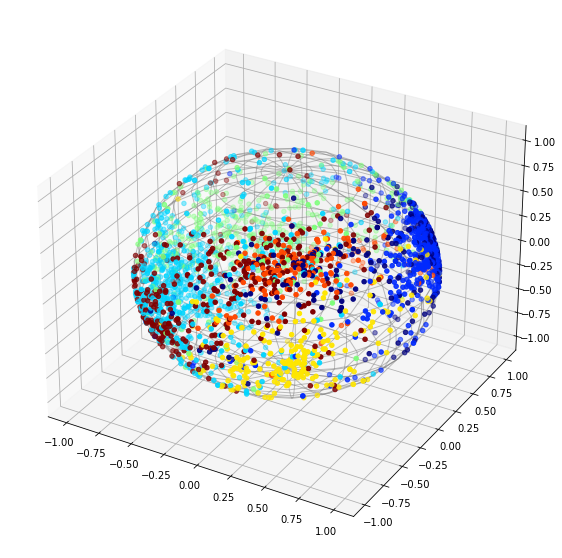

In [8]:
dropout = .4
svgae_hidden_dims = [512,3]
n_epochs=400
patience=40

hyperparameters = {}
hyperparameters['lr'] = .001
hyperparameters['weight_decay'] = 0.
hyperparameters['neg_sample_size'] = 1
hyperparameters['KL_weight'] = 1.

# Train model
svgae = VGAE(g,in_feats,svgae_hidden_dims,activation=F.relu,dropout=dropout,distribution='hypersphere')
process.train_model(svgae,features,hyperparameters,'cora_svgae', \
                    n_epochs=n_epochs,patience=patience, \
                    saved_dir='saved_models',verbose=False)

# Load model
svgae.load_state_dict(torch.load(os.path.join('saved_models', \
                                            'cora_svgae.pkl')))

# Embed nodes with model
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
embeds = nvgae.encoder(features)
(embeds, embeds_var) = svgae.encoder(features)
embeds = embeds.detach()

# Visualize
import mpl_toolkits.mplot3d.axes3d as axes3d
# let's visualize samples in the sphere

theta, phi = np.linspace(0, 2 * np.pi, 20), np.linspace(0, np.pi, 20)
THETA, PHI = np.meshgrid(theta, phi)
X, Y, Z = np.sin(PHI) * np.cos(THETA), np.sin(PHI) * np.sin(THETA), np.cos(PHI)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_wireframe(X, Y, Z, linewidth=1, alpha=0.5, color="grey")

ax.scatter(embeds[:,0],embeds[:,1],embeds[:,2],c=labels,cmap='jet')

Deep Graph Infomax

Model: Deep Graph Infomax
Epoch 00399 | Time(s) 0.0913 | Loss 0.0273 | Last epoch! 


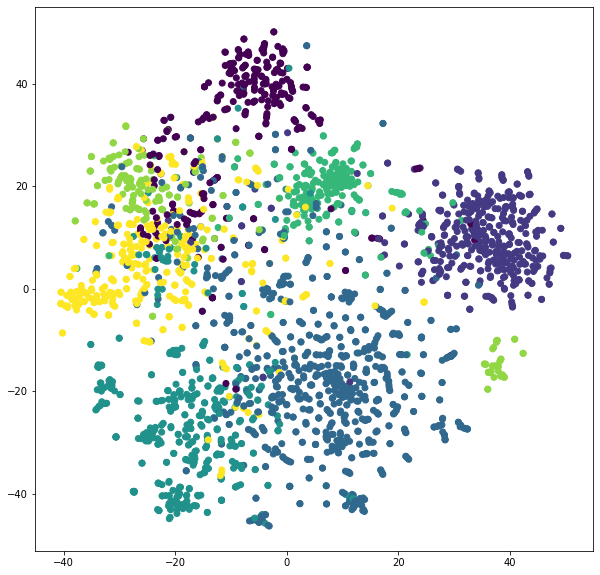

In [9]:
dropout = .4
hidden_dims = [256,256]
activation = nn.PReLU(hidden_dims[-1])
n_epochs=400
patience=40

hyperparameters = {}
hyperparameters['lr'] = .001
hyperparameters['weight_decay'] = 0.

# Train model
dgi = DGI(g,in_feats,hidden_dims,activation=activation,dropout=dropout)
process.train_model(dgi,features,hyperparameters,'cora_dgi', \
                    n_epochs=n_epochs,patience=patience, \
                    saved_dir='saved_models',verbose=False)

# Load model
dgi.load_state_dict(torch.load(os.path.join('saved_models', \
                                            'cora_dgi.pkl')))

# Embed nodes with model
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
embeds = dgi.encoder(features, corrupt=False)
embeds = embeds.detach()

# Visualize
tsne = TSNE(n_components=2, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(embeds)
x = tsne_results[:,0]
y = tsne_results[:,1]
fig = plt.figure(figsize=(10,10))
plt.scatter(x,y,c=labels,alpha=1.)